In [20]:
# Installiamo la libreria 'arch' per i modelli GARCH
# e le altre librerie standard
!pip install yfinance arch -q

# Importiamo le librerie
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model # La componente chiave per il nostro modello

# Impostiamo uno stile grafico
sns.set_style('whitegrid')
plt.rc('figure', figsize=(12, 6))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 17.8 MB/s eta 0:00:00


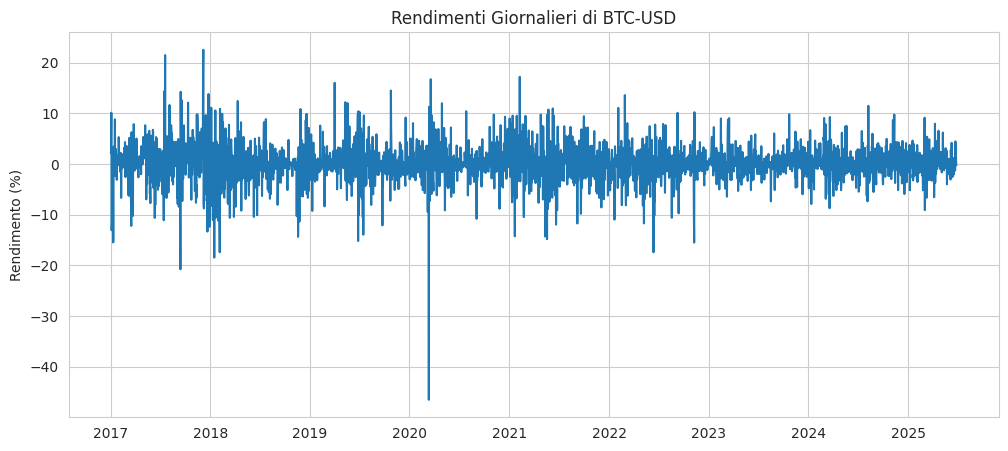

In [21]:
# Definiamo l'asset e il periodo di analisi
# Usiamo un periodo lungo per dare al modello dati sufficienti per "imparare"
ticker = 'BTC-USD'
start_date = '2017-01-01'

# Scarichiamo i dati
data = yf.download(ticker, start=start_date, progress=False)

# Calcoliamo i rendimenti logaritmici giornalieri, moltiplicati per 100
# I modelli GARCH funzionano meglio con rendimenti in formato percentuale
returns = 100 * np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Visualizziamo i rendimenti
plt.figure(figsize=(12, 5))
plt.plot(returns)
plt.title(f'Rendimenti Giornalieri di {ticker}')
plt.ylabel('Rendimento (%)')
plt.show()

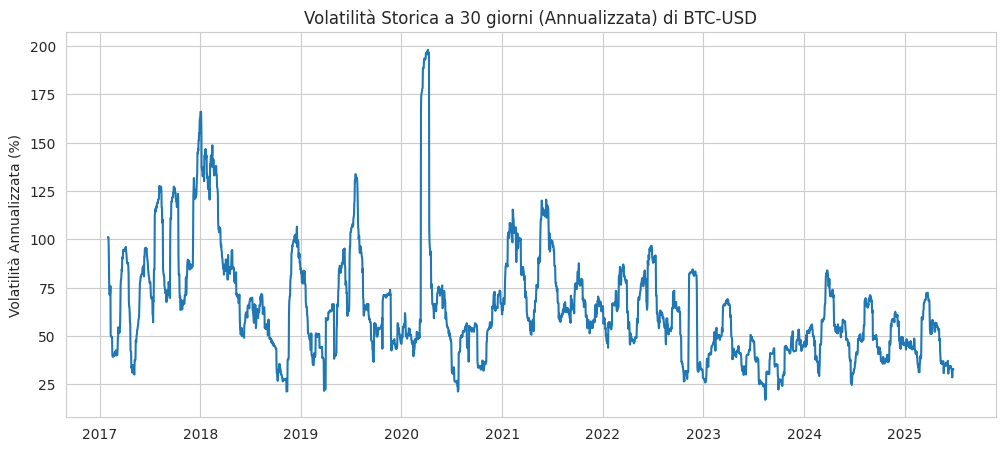

In [22]:
# Calcoliamo la volatilità storica (realizzata) annualizzata
# Usiamo una finestra mobile di 30 giorni sulla deviazione standard dei rendimenti
# Annualizziamo moltiplicando per la radice di 365 (Bitcoin scambia 24/7)
realized_vol = returns.rolling(window=30).std() * np.sqrt(365)

# Visualizziamo la volatilità storica
plt.figure(figsize=(12, 5))
plt.plot(realized_vol)
plt.title(f'Volatilità Storica a 30 giorni (Annualizzata) di {ticker}')
plt.ylabel('Volatilità Annualizzata (%)')
plt.show()

In [23]:
# Definiamo il modello GARCH(1,1)
# vol='Garch' specifica il tipo di modello
# p=1 è il termine ARCH (legato ai rendimenti passati)
# q=1 è il termine GARCH (legato alla volatilità passata)
garch_model = arch_model(returns, vol='Garch', p=1, q=1)

# "Fittiamo" il modello ai nostri dati
# disp='off' per non mostrare i messaggi di convergenza durante la stima
results = garch_model.fit(disp='off')

# Stampiamo un sommario dei risultati del modello
print(results.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                BTC-USD   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8217.84
Distribution:                  Normal   AIC:                           16443.7
Method:            Maximum Likelihood   BIC:                           16467.8
                                        No. Observations:                 3098
Date:                Thu, Jun 26 2025   Df Residuals:                     3097
Time:                        13:20:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1864  6.079e-02      3.066  2.166e-03 [6.726e-0

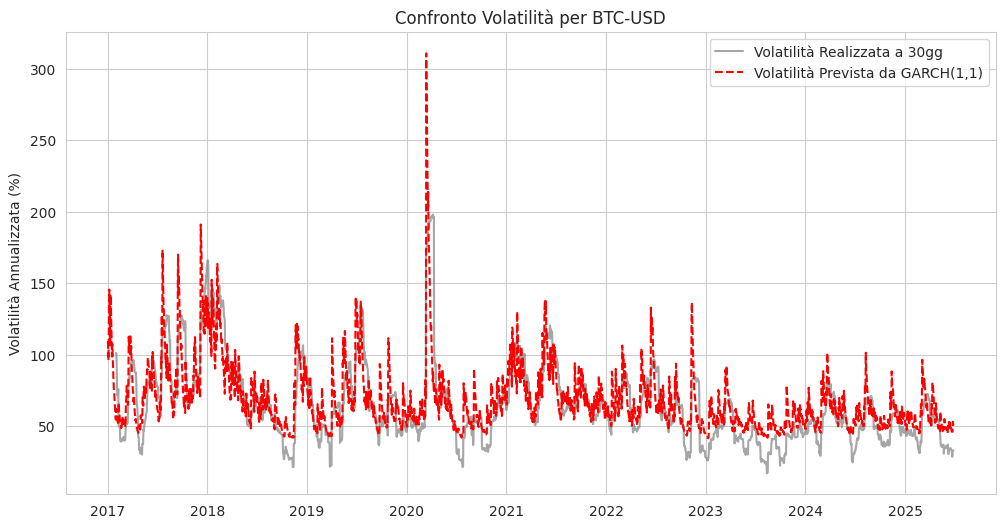

In [24]:
# Otteniamo la volatilità condizionale dal nostro modello fittato
conditional_vol = results.conditional_volatility

# Annualizziamo la volatilità del modello GARCH
garch_vol = conditional_vol * np.sqrt(365)

# Creiamo un grafico di confronto
plt.figure(figsize=(12, 6))
# Volatilità storica (la nostra "verità di mercato")
plt.plot(realized_vol, label='Volatilità Realizzata a 30gg', color='grey', alpha=0.7)
# Volatilità stimata dal modello GARCH
plt.plot(garch_vol, label='Volatilità Prevista da GARCH(1,1)', color='red', linestyle='--')

plt.title(f'Confronto Volatilità per {ticker}')
plt.ylabel('Volatilità Annualizzata (%)')
plt.legend()
plt.show()

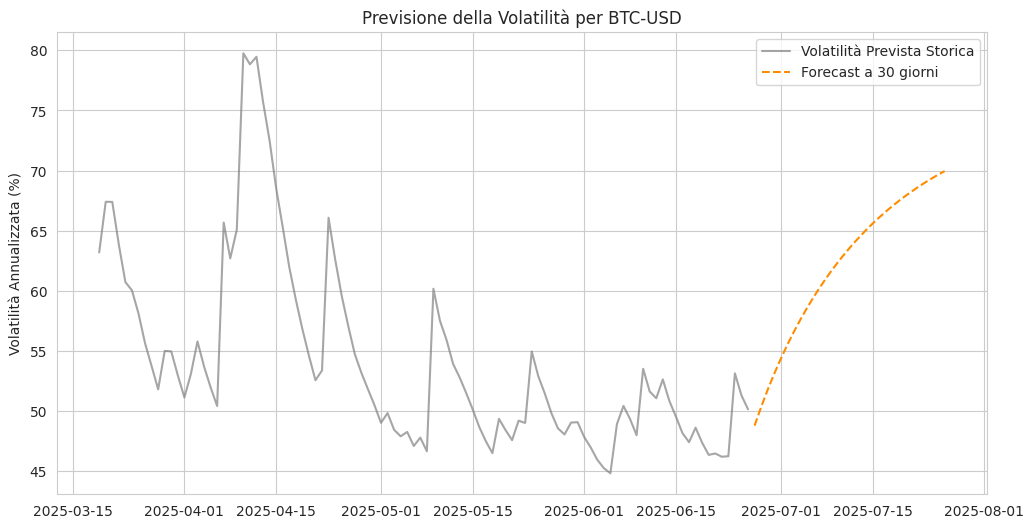


--- Previsione della Volatilità ---
Volatilità prevista per domani: 48.77%
Volatilità media prevista per i prossimi 30 giorni: 62.13%


In [32]:
# Eseguiamo un forecast per i prossimi 30 giorni
forecast_horizon = 30
forecast = results.forecast(horizon=forecast_horizon)

# Estraiamo la varianza prevista (dobbiamo fare la radice quadrata per la volatilità)
# .iloc[-1] per prendere l'ultima previsione disponibile basata su tutti i dati
forecast_variance = forecast.variance.iloc[-1]
forecast_volatility = np.sqrt(forecast_variance)

# Annualizziamo la previsione
annualized_forecast_vol = forecast_volatility * np.sqrt(365)

# Visualizziamo la previsione
plt.figure(figsize=(12, 6))

# Get the date index from garch_vol
plot_dates = garch_vol.index[-100:]

# Volatilità storica (la nostra "verità di mercato")
plt.plot(plot_dates, garch_vol.tail(100), label='Volatilità Prevista Storica', color='grey', alpha=0.7) # Ultimi 100 giorni
# Volatilità stimata dal modello GARCH
# Create a date range for the forecast starting from the day after the last historical data point
forecast_dates = pd.date_range(start=plot_dates[-1] + pd.Timedelta(days=1), periods=forecast_horizon)
plt.plot(forecast_dates, annualized_forecast_vol, label=f'Forecast a {forecast_horizon} giorni', color='darkorange', linestyle='--')


plt.title(f'Previsione della Volatilità per {ticker}')
plt.ylabel('Volatilità Annualizzata (%)')
plt.legend()
plt.show()

print("\n--- Previsione della Volatilità ---")
print(f"Volatilità prevista per domani: {annualized_forecast_vol.iloc[0]:.2f}%")
print(f"Volatilità media prevista per i prossimi {forecast_horizon} giorni: {annualized_forecast_vol.mean():.2f}%")